![sutd](./imgs/sutd.png)
## <center>50.040 Natural Language Processing, Summer 2020<center>
<center>**Homework 4**

### Requirements:
- Use Python to complete this homework.
- Please list students with whom you have discussed (if any).
- Follow the honor code strictly.

In this homework, we'll implement ``IBM Model 1`` using the ``expectation–maximization (EM)`` algorithm. We need to estimate the  translation probabilities  $t(f|e)$ on a parallel corpus, where $e$ is a word from the English sentences and $f$ is a word from the corresponding foreign sentences. 

Note that there's a constraint for such probabilities:
$$\sum_f t(f|e)=1 , \ \ \  t(f|e) \ge 0  \quad (1)$$

**We'll use this constraint when initializing the translation probabilities in subsequent tasks.**

## Data
We'll use the English-French parallel corpus under the folder ``data/part1``, which contains a set of translation instances. As can be seen below each instance consists of an English-French sentence pair (note that we are translating from French into English, but as we discussed in class, when working on the translation model using IBM model 1, we are interested in generating French from English).



    Hop in.	Montez.
    Hug me.	Serre-moi dans tes bras !
    I left.	Je suis parti.

The dataset is obtained from [MXNET](http://data.mxnet.io/data/fra-eng.zip). Please run the provided code below to obtain the preprocessed English sentences and French sentences. Do not perform any further preprocessing. 


In [1]:
import seaborn as sns
import numpy as np
from time import time
from collections import Counter, defaultdict

from matplotlib import pyplot as plt
%matplotlib inline

# Part 1: Statistical Machine Translation \[25 points]

In [2]:
path = 'data/part1/en-fr.txt'
with open(path, 'r', encoding='utf8') as f:
    raw_text = f.read()

#Original code from 
#https://www.d2l.ai/chapter_recurrent-neural-networks
def preprocess_nmt(text):
    '''
    Arg:
        text: parallel text, string
    Return:
        out: preprocessed text, string
    '''
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    no_space = lambda char, prev_char: (
        True if char in (',', '!', '.') and prev_char != ' ' else False)
    out = [' '+char if i > 0 and no_space(char, text[i-1]) else char
           for i, char in enumerate(text.lower())]
    out = ''.join(out)
    return out

def tokenize_nmt(text, num_examples = None):
    '''
    Args:
        text: parallel text, string
        num_examples: number of examples to be selected, int
    Returns:
        left: English sentences, list
        right: French sentences, list
    '''
    left, right = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            left.append(parts[0].split(' '))
            right.append(parts[1].split(' '))
    return left, right


In [3]:
#English sentences and corresponding French sentences
#Each sentence has been preprocessed and tokenized
text = preprocess_nmt(raw_text)
english_sents, french_sents = tokenize_nmt(text)

In [4]:
english_sents[:10], french_sents[:10]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who?'],
  ['wow', '!'],
  ['fire', '!'],
  ['help', '!'],
  ['jump', '.'],
  ['stop', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!'],
  ['au', 'feu', '!'],
  ['à', "l'aide", '!'],
  ['saute', '.'],
  ['ça', 'suffit', '!']])


### Quesiton 1 (3 points)
1. Implement ``word_pairs_in_corpus`` which finds out all the possible word pairs (alignments) $(e, f)$ that appear in all the instances of the English-French dataset ``english_sents``, ``french_sents``. Note that we need to pad each English sentence with the special token "NULL" at the beginning.
2. List down the 10 most frequent pairs. 
3. Count the number of unique pairs.

In [5]:
def word_pairs_in_corpus(en_sents, fr_sents):
    '''
    params:
        en_sents: list[list[str]]
        fr_sents: list[list[str]]
    return:
        align_counts: Dict()--- key: (english_word, french_word), value: counts of the word pair in the corpus
    '''
    align_counts = None
    # YOUR CODE HERE
    align_counts = Counter()
    for idx_sent, en_sent in enumerate(en_sents):
        fr_sent = fr_sents[idx_sent]
        for m in fr_sent:
            for n in en_sent:            
                align_counts[(n, m)] += 1
    
    # END OF YOUR CODE
    return align_counts

In [6]:
english_sents = [['NULL'] + sent for sent in english_sents]
align_counts = word_pairs_in_corpus(english_sents, french_sents)
align_counts.most_common(10), len(align_counts)

([(('.', '.'), 136734),
  (('NULL', '.'), 135221),
  (('i', '.'), 43189),
  (('NULL', 'je'), 39821),
  (('.', 'je'), 39096),
  (('NULL', 'de'), 35073),
  (('i', 'je'), 34415),
  (('to', '.'), 31647),
  (('.', 'de'), 30490),
  (('the', '.'), 29170)],
 1402126)

In [7]:
en_vocab = set([item[0] for item in align_counts.keys()])
fr_vocab = set([item[1] for item in align_counts.keys()])

In [8]:
len(en_vocab), len(fr_vocab)

(17430, 29741)

### Question 2 (2 points):

Implment the ``corpus_log_prob `` that computes the log probability of the corpus

In [9]:
def corpus_log_prob(en_sents, fr_sents, t):
    '''
    params:
        en_sents: list[list[str]]
        fr_sents: list[list[str]]
        t: Dict() --- contains translation probabilities. For example, t[(english_word, french_word)] = p
    return:
        logp: float --- log probability of the corpus
    '''
    logp = 0
    ### YOUR CODE HERE    
    for idx_sent, en_sent in enumerate(en_sents):
        fr_sent = fr_sents[idx_sent]
        logp_temp = 0
        for f in fr_sent:
            p_temp = 0
            for e in en_sent:
                p_temp += t[(e,f)]
            logp_temp += np.log(p_temp)
        logp += logp_temp        
                
    # END OF YOUR CODE
    return logp

## Hard EM algorithm

### Question 3 (10 points)
Based on the word pairs obtained in Q1, implement ``Hard EM algorithm`` to calculate the  translation probabilities  $t(f|e)$ on the English-French corpus. 

It is possible that in the hard EM algorithm a word $\tilde{e}$ from an English sentence may not be aligned with any word from the corresponding French sentence. In this case, let us set the corresponding probabilities $t(f|\tilde{e})=\frac{1}{|V_f|}$ where $|V_f|$ is the size of the French vocabulary (in this case, the number of unique French words that ever appear in the training parallel corpus).

1. Implement ``init`` function which initializes the translation probability dictionary $t$ according to equation (1). You need to use ``numpy.random.rand()`` in this part.
2. Implement ``hard_EM`` function which runs one ``Expectation/Maximization`` iteration.
3. Run the training code

In [10]:
def init(word_pairs):
    '''
    Use np.random.rand() to initialize translation probabilities t(f|e)
    params:
        word_pairs: List[(str, str)] --- list of word pairs
    return:
        t: Dict(), key: (english_word, french_word), value: the initial probability t(f|e). For example, t[(a, un)] = 0.5
    '''
    np.random.seed(5)
    t = dict()
    ### YOUR CODE HERE     

    t_temp = defaultdict(lambda:[])
    for word_pair in word_pairs:
        t_temp[word_pair[0]].append(word_pair[1])    

    for e, f_list in t_temp.items():
        prob = np.random.rand(len(f_list)) 
        prob /= np.sum(prob)
        for f_idx, f in enumerate(f_list):        
            t[(e,f)] = prob[f_idx]
    
    ### END OF YOUR CODE
    return t

In [11]:
def hard_EM(en_sents, fr_sents, fr_vocab, t):
    '''
    One 'Expectation', 'Maximization' iteration.
    params:
        en_sents: List[List[str]]
        fr_sents: List[List[str]]
        fr_vocab: int --- size of the French vocab
        t: Dict() --- translation probability dictionary from last iteration
        
    return:
        new_t: Dict() --- updated parameters, dictionary
    '''
    new_t = t
    ### YOUR CODE HERE 
    
    # Expectation Step
    count = defaultdict(lambda:defaultdict(lambda:0))
    for idx_sent, en_sent in enumerate(en_sents):
        fr_sent = fr_sents[idx_sent]        
        for f_idx, f in enumerate(fr_sent):
            temp_t = []
            for e in en_sent:
                temp_t.append(t[(e,f)])                 
            max_e_idx = np.argmax(temp_t)             
            for e_idx, e in enumerate(en_sent):
                if e_idx == max_e_idx:  
                    max_e = en_sent[max_e_idx]
                    count[max_e][f] += 1
                else:                    
                    count[e][f] += 0            

    # Maximization Step  
    for e, f_dict in count.items():
        count_e = 0
        for f, cnt in f_dict.items():
            count_e += cnt 
        for f, cnt in f_dict.items():
            count_e_f = cnt            
            if cnt == 0:   
                new_t[(e,f)] = 1.0 / len(fr_vocab)
            else:
                new_t[(e,f)] = count_e_f / count_e   
    
    ### END OF YOUR CODE
    
    return new_t

In [12]:
############################################################
# Randomly initialized the probabilities under the contraint
############################################################
hard_t = init(list(align_counts.keys()))
    
##################
# Hard EM training
##################
iteration = 0
while iteration < 10:
    
    logp = corpus_log_prob(english_sents, french_sents, hard_t)    
    hard_t = hard_EM(english_sents, french_sents, fr_vocab, hard_t)  
    print('Objective Function:', round(logp, 5))
    iteration += 1   


Objective Function: -5664962.50876
Objective Function: -2944312.93572
Objective Function: -2267714.89078
Objective Function: -2154345.55611
Objective Function: -2124165.26482
Objective Function: -2087355.46163
Objective Function: -2081644.83971
Objective Function: -2076870.66956
Objective Function: -2075318.85863
Objective Function: -2074588.65441


### Visualization
Using 2D-heatmap, visualize the translation probability (namely $t(f|e)$) for each of the instances below:

    NULL tom loves chocolate .   tom adore le chocolat .    
    NULL it was a very exciting game .   c'était un jeu vraiment très excitant .  

In [13]:
def visualize_trans_prob(en, fr, t):
    '''
    Visualize the translation probability of an instance
    '''
    alignments = np.zeros([len(fr), len(en)])
    for i in range(len(fr)):
        for j in range(len(en)):
            alignments[i, j] = t[(en[j], fr[i])]
    sns.heatmap(alignments, cmap='PuBuGn', annot=True)
    _, _ = plt.yticks(np.arange(len(fr))+0.5, fr, rotation=0, fontsize=10)
    _, _ = plt.xticks(np.arange(len(en))+0.5, en, rotation=30, fontsize=10)

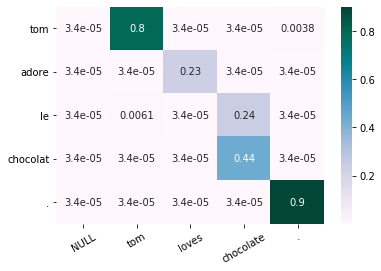

In [14]:
en = "NULL tom loves chocolate .".split()
fr = "tom adore le chocolat .".split()
visualize_trans_prob(en, fr, hard_t)

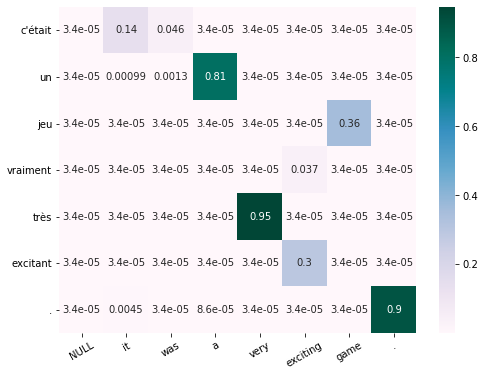

In [15]:
plt.figure(figsize=(8, 6))
en = "NULL it was a very exciting game .".split()
fr = "c'était un jeu vraiment très excitant .".split()
visualize_trans_prob(en, fr, hard_t)

## Soft EM algorithm

### Question 4 (10 points)

1. Implement ``soft_EM`` function which runs one ``Expectation/Maximization`` iteration.
2. Run the training code

In [16]:
def soft_EM(en_sents, fr_sents, t):
    '''
    params:
        en_sents: English sentences, list
        fr_sents: foreign sentences, list
    return:
        t: updated parameters, dictionary
    '''
    new_t = t
    ### YOUR CODE HERE
    
    # Expectation Step
    count = defaultdict(lambda:defaultdict(lambda:0))
    for idx_sent, en_sent in enumerate(en_sents):
        fr_sent = fr_sents[idx_sent]        
        for f_idx, f in enumerate(fr_sent):
            temp_t = []
            for e in en_sent:
                temp_t.append(t[(e,f)])                 
            total = np.sum(temp_t)             
            for e_idx, e in enumerate(en_sent):                  
                count[e][f] += t[(e,f)] / total            

    # Maximization Step  
    for e, f_dict in count.items():
        count_e = 0
        for f, cnt in f_dict.items():
            count_e += cnt 
        for f, cnt in f_dict.items():
            count_e_f = cnt    
            new_t[(e,f)] = count_e_f / count_e 
    
    ### END OF YOUR CODE
    return new_t

Let us check the algorithm first using the objective value.

In [17]:
############################################################
# Randomly initialized the probabilities under the contraint
############################################################
soft_t = init(list(align_counts.keys()))
    
##################
# Hard EM training
##################
iteration = 0
while iteration < 15:
    
    logp = corpus_log_prob(english_sents, french_sents, soft_t)    
    soft_t = soft_EM(english_sents, french_sents, soft_t)  
    print('Objective Function:', round(logp, 5))
    iteration += 1

Objective Function: -5664962.50876
Objective Function: -2773514.34228
Objective Function: -1958956.26452
Objective Function: -1716764.8015
Objective Function: -1634081.04637
Objective Function: -1598953.54084
Objective Function: -1581652.28991
Objective Function: -1572232.47631
Objective Function: -1566655.84782
Objective Function: -1563116.71582
Objective Function: -1560745.78793
Objective Function: -1559093.83474
Objective Function: -1557904.95152
Objective Function: -1557024.99939
Objective Function: -1556354.76044


### Visualization

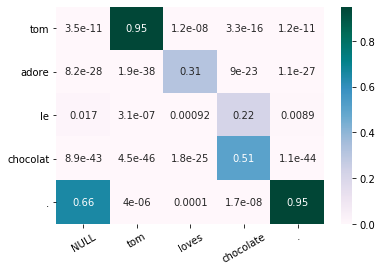

In [18]:
en = "NULL tom loves chocolate .".split()
fr = "tom adore le chocolat .".split()
visualize_trans_prob(en, fr, soft_t)

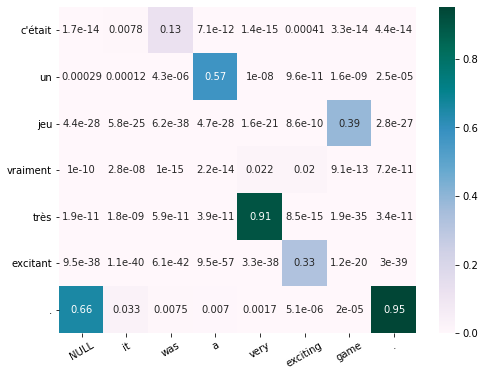

In [19]:
plt.figure(figsize=(8,6))
en = "NULL it was a very exciting game .".split()
fr = "c'était un jeu vraiment très excitant .".split()
visualize_trans_prob(en, fr, soft_t)